In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
from warnings import filterwarnings
from chainer import serializers
#print(check_output(["dir", "C:/Users/User/Documents/RL_"]).decode("utf8"))
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
filterwarnings(action='ignore', category=np.VisibleDeprecationWarning)  
# Any results you write to the current directory are saved as output.

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
D:\Anaconda\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
import time
import copy
import numpy as np
import array as arr
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt
from plotly.offline import plot
import datetime
import plotly.graph_objects as go
#from plotly import tools
#from plotly.graph_objs import *
#from plotly.offline import init_notebook_mode, iplot, iplot_mpl

In [3]:
data = pd.read_csv('C:/Users/User/Documents/RL_/Data/Stocks/SPY.txt')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.index.min(), data.index.max())
data.head()

2001-01-02 00:00:00 2019-12-30 00:00:00


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


In [4]:
start_date = datetime.datetime(2001, 1, 1)
end_date = datetime.datetime(2019, 12, 31)
total_days = (end_date - start_date).days
train_days = int(total_days * 0.5)
test_start_date = start_date + datetime.timedelta(days=train_days)
date_split = test_start_date.date()
train = data[:date_split]
test = data[date_split:]
print("訓練", start_date.date(), "到", test_start_date.date())
print("測試", test_start_date.date(), "到", end_date.date())

訓練 2001-01-01 到 2010-07-02
測試 2010-07-02 到 2019-12-31


In [5]:
def plot_train_test(train, test, date_split):
    # 创建图形
    train_candle = go.Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Close'], name='Train')
    test_candle = go.Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Close'], name='Test')
    
    fig = go.Figure(data=[train_candle, test_candle])
    
    # 添加分割线
    fig.add_shape(
        type="line",
        x0=date_split, y0=min(min(train['Low']), min(test['Low'])),
        x1=date_split, y1=max(max(train['High']), max(test['High'])),
        line=dict(color="Black", width=2)
    )
    
    # 添加注释
    fig.add_annotation(
        x=date_split, y=max(max(train['High']), max(test['High'])), ax=0, ay=-30,
        xref='x', yref='y',
        showarrow=True, arrowhead=1,
        text="Start of Test Data"
    )
    
    # 更新布局
    fig.update_layout(title='Train and Test Data Visualization', xaxis_title='Date', yaxis_title='Price')
    
    # 显示图形
    plot(fig)

# 调用函数
plot_train_test(train, test, date_split)

In [5]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 10000 #初始資金
        self.count = []
        self.positions = []
        self.position_value = 0
        self.brok_rate=0.0009
        self.max_trade_percent = 0.8
        self.tbrokerage = 0
        self.history = [0 for _ in range(self.history_t)]
        self.Act0=0
        self.Act1=0
        self.Act2=0
        self.RW_p=0
        self.RW_n=0
        self.RW_p_v=0
        self.RW_n_v=0
        return [self.position_value] + self.history # obs
    
    def step(self, act, amount):
        if self.t >= len(self.data) - 1:
            self.done = True
            return [self.position_value] + self.history, 0, self.done
        reward = 0
        #print(act)
        #print(amount)
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            if self.profits != 0:
                max_trade_amount = self.profits*self.max_trade_percent
                stock_price = self.data.iloc[self.t, :]['Close']
                count = max_trade_amount / stock_price
                #self.tbrokerage = self.brok_rate*self.data.iloc[self.t, :]['Close']
                buyin = stock_price * count
                self.profits = self.profits - buyin 
                #print('\t'.join(map(str, ['buy',self.data.iloc[self.t, :]['Close'], amount, buyin, self.profits])))
                self.positions.append(stock_price)
                self.count.append(count)
                self.Act1+=1
                #print('\t'.join(map(str, ['buy', amount, buyin, self.profits])))
                
        elif act == 2: # sell
            if len(self.positions) > 0:
                sell_ratio = self.determine_sell_ratio(amount)
                num_positions_to_sell = int(len(self.positions) * sell_ratio)

                for i in range(num_positions_to_sell):
                    sell_price = self.data.iloc[self.t, :]['Close']
                    buy_price = self.positions[i]
                    count = self.count[i]
                    abs_num = (sell_price - buy_price) * count
                    if abs_num > 0: 
                        self.RW_p += 1 
                        self.RW_p_v += abs_num
                    else: 
                        self.RW_n += 1
                        self.RW_n_v += abs(abs_num)
                    reward += sell_price * count
                    self.profits += sell_price * count
                self.positions = self.positions[num_positions_to_sell:]
                self.count = self.count[num_positions_to_sell:]
                self.Act2 += 1    
        
        else :
            self.Act0+=1
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done
    def determine_sell_ratio(self, signal_strength):
        # Example thresholds and ratios
        thresholds = [0.2, 0.5, 0.8]
        ratios = [0.25, 0.5, 0.75]

        for i, threshold in enumerate(thresholds):
            if signal_strength < threshold:
                return ratios[i]
        return ratios[0]  # Sell the largest ratio but not everything if the signal is very strong

In [7]:
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    amount = 0.333
    print(env.step(pact,amount))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64.2900390625], 0, False)
([-14.2200927734375, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64.2900390625, -14.2200927734375], 0, False)
([-49.2100830078125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [8]:
# DQN

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 200
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 1
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
    start = time.time()

    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
                
            # select act
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                #pact = np.argmax(softmax_q_values)
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            #log_profits = 0
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    chainer.serializers.save_npz('2001_SPY_dqn_model.npz', Q)        
    return Q, total_losses, total_rewards
    

In [9]:
Q, total_losses, total_rewards = train_dqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	8063.725664544497	475	302	1611
1	235	227	12025.405927966984	13921.165996076066
2	8566.693979351236	252	168	1968
2	140	106	9556.563478595892	10863.806736188277
3	8510.848925747567	318	162	1908
3	167	144	10817.415461089844	11799.949805208129
4	8271.099835132953	257	214	1916
4	148	103	9031.304642565754	10250.390845943062
5	8282.591200901037	325	182	1880
5	183	136	10412.826595626157	11580.290092419182
6	9525.262207260466	327	200	1861
6	178	146	10202.066845922363	9989.33874752182
7	7304.406041918396	387	192	1809
7	205	174	9581.501445308211	11640.757020747946
8	6051.9662768654	410	150	1828
8	207	197	7704.795560476829	11228.427268225229
9	10385.916083169745	411	193	1784
9	242	166	12307.981112164854	11471.723896292064
10	9075.296039957386	440	162	1786
10	254	178	11643.479935182586	11976.081967586832
11	9990.781932699989	552	139	1697
11	296	239	13542.884925744349	11942.954759955144
12	6809.549207969139	517	147	1724
12	291	201	10530.79534370157	13310.07959

102	8659.941009644524	522	102	1764
102	301	215	11702.890940508069	12434.676856460574
103	8297.945016486365	594	79	1715
103	297	275	10455.523156346075	10849.238918002142
104	7417.206374789909	577	76	1735
104	303	253	10088.801322652867	11402.255914491092
105	8721.336918150457	516	102	1770
105	318	187	10065.289018193269	10820.410700394434
106	8864.818154989465	534	113	1741
106	273	237	11902.878420966816	12436.111517871612
107	10528.894398132854	570	68	1749
107	354	211	11212.07999188212	10216.924328127723
108	7509.034790286534	602	99	1687
108	317	266	10742.69590357414	13185.976931771578
109	7286.776854523952	572	91	1725
109	315	246	8765.944590284234	11241.42101137893
110	8618.113380045124	591	77	1720
110	356	225	9066.347010343638	9955.79769880594
111	8496.637502804806	563	92	1733
111	301	258	11775.089685198256	12901.943363953138
112	9708.30294894346	576	86	1726
112	302	269	12670.161348609536	12101.208663727659
113	11038.280093679823	557	89	1742
113	301	244	12470.186511308044	10060.60647984

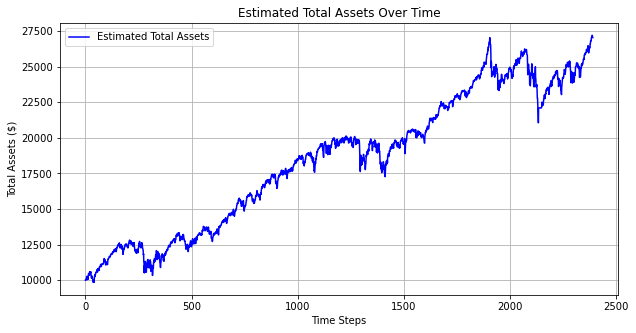

Final profits: 27037.5752072052


In [19]:
import matplotlib.pyplot as plt
#buy_threshold=0.11803, sell_threshold=0.56895
def test_dqn(test_env, Q, confidence_threshold_buy=0.1, confidence_threshold_sell=0.8):
    # 重置环境
    pobs = test_env.reset()
    test_env.profits = 10000  # 重置初始资金
    test_acts = []
    test_rewards = []
    estimated_total_assets = [test_env.profits]  # 记录每步的总资产，初始资金为起始值

    while not test_env.done:
        # 使用DQN产生行动的概率分布
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data
        pact = np.random.choice(3, p=softmax_q_values.ravel())
        
        # 根据设定的阈值判断是否执行买入或卖出
        amount = softmax_q_values.ravel()[pact]
        if pact == 2 and amount < confidence_threshold_sell:
            pact = 0
        elif pact == 1 and amount < confidence_threshold_buy:
            pact = 0
        
        # 执行行动
        obs, reward, done = test_env.step(pact, amount)
        test_acts.append(pact)
        test_rewards.append(reward)
        pobs = obs

        # 估算总资产
        stock_value = sum(c * test_env.data.iloc[test_env.t]['Close'] for c in test_env.count)
        total_assets = test_env.profits + stock_value
        estimated_total_assets.append(total_assets)

    # 绘制估算总资产的折线图
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    final_profits = total_assets
    return test_acts, test_rewards, final_profits
def load_and_test_dqn(test_env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
    chainer.serializers.load_npz('2001_SPY_dqn_model.npz', Q_loaded)
    
    # 现在使用加载的模型来进行测试
    test_acts, test_rewards, test_profits = test_dqn(test_env, Q_loaded)
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    print("Final profits:", test_profits)
# 调用函数进行测试
test_data = test  # 确保已正确设置测试数据
test_env = Environment1(data=test_data, history_t=90)
load_and_test_dqn(test_env)

In [11]:
def plot_loss_reward(total_losses, total_rewards):

    figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('loss', 'reward'), print_grid=False)
    figure.append_trace(Scatter(y=total_losses, mode='lines', line=dict(color='skyblue')), 1, 1)
    figure.append_trace(Scatter(y=total_rewards, mode='lines', line=dict(color='orange')), 1, 2)
    figure['layout']['xaxis1'].update(title='epoch')
    figure['layout']['xaxis2'].update(title='epoch')
    figure['layout'].update(height=400, width=900, showlegend=False)
    iplot(figure)
    

In [12]:
# Double DQN

def train_ddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()    
    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 200
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    gamma = 0.97
    show_log_freq = 1

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    save_models(Q, Q_ast)       
    return Q, total_losses, total_rewards
def save_models(Q, Q_ast, behavior_filename='2001_SPY_ddqn_behavior_model.npz', target_filename='2001_SPY_ddqn_target_model.npz'):
    serializers.save_npz(behavior_filename, Q)
    serializers.save_npz(target_filename, Q_ast)

In [13]:
Q, total_losses, total_rewards = train_ddqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	10554.493774168272	502	422	1462
1	259	236	16351.441606136015	14815.289383753856
2	5514.5595806649135	444	210	1734
2	222	214	7690.527289670686	11653.964782263834
3	9330.30322078594	450	176	1762
3	272	171	11338.278046253878	11889.23692505316
4	8226.698338517477	512	141	1735
4	291	209	11180.715261759355	11624.375439195033
5	7769.674425380404	577	125	1686
5	300	271	10542.982881849359	12115.2092899241
6	9641.840964582829	665	105	1618
6	364	293	13024.356852764116	12987.71635835195
7	11479.810608547454	600	99	1688
7	350	241	16571.544377672817	13487.618047681684
8	9722.430363392605	747	92	1549
8	456	255	11559.322541812155	10411.069998672814
9	6961.717370627845	672	113	1603
9	368	294	6664.863736921122	9650.214301060338
10	7355.380746297597	710	95	1583
10	374	318	8948.896183178204	11157.912288227702
11	7825.061625019723	647	78	1663
11	337	278	7513.152863318249	9298.788746218093
12	10485.018948624325	666	91	1631
12	353	268	11337.510760225383	10130.534729030

102	8690.826863893642	577	93	1718
102	330	225	10749.848598664861	10750.698412374033
103	7281.045160900625	534	74	1780
103	297	222	10450.604017278712	11855.816774363544
104	7792.969311680116	547	83	1758
104	302	236	8245.794649529667	9922.610896327706
105	8380.591929725844	562	73	1753
105	313	239	9997.983442865801	10464.040486572343
106	6356.4521916824015	560	93	1734
106	292	250	9995.363640315752	12732.64809588571
107	8698.889632712995	593	81	1714
107	347	223	11317.965795744985	11038.789977406681
108	11864.238141796384	626	91	1670
108	370	247	14487.848821894826	11970.965243101793
109	9860.453600586572	569	76	1743
109	345	220	12209.765033680595	12349.305254437337
110	8393.31796304039	577	75	1736
110	316	230	9526.76230217044	10283.967566575991
111	7735.258737995845	590	86	1712
111	313	274	11542.842496635958	13693.925312169902
112	9480.970109022932	511	96	1781
112	281	214	13110.125659577374	12197.196840197948
113	7186.0487691614735	497	101	1790
113	296	193	10050.870579030528	11754.662753574

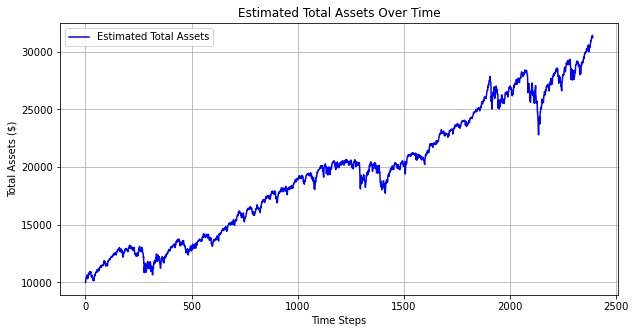

Final profits: 31237.614597027423


In [18]:
import matplotlib.pyplot as plt

def test_ddqn(test_env, Q, Q_ast, buy_threshold=0.1, sell_threshold=0.8):
    # 重置环境并获取初始状态
    pobs = test_env.reset()
    test_env.profits = 10000  # 如果需要的话，重置初始资金
    test_acts = []
    test_rewards = []
    test_profits = [test_env.profits]  # 记录每一步后的利润
    estimated_total_assets = [test_env.profits]  # 包括估算的持股价值的总资产列表

    while not test_env.done:
        # 使用训练好的DDQN模型选择行动
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data.ravel()
        action = np.random.choice(3, p=softmax_q_values)
        action_prob = softmax_q_values[action]
        amount = action_prob

        # 根据阈值判断是否执行买入或卖出
        if action == 1 and action_prob < buy_threshold:
            action = 0
            amount = 0
        elif action == 2 and action_prob < sell_threshold:
            action = 0
            amount = 0

        obs, reward, done = test_env.step(action, amount)
        if done:
            break
        test_acts.append(action)
        test_rewards.append(reward)
        pobs = obs
        test_profits.append(test_env.profits)

        # 估算总资产（不实际卖出股票）
        stock_value = sum(c * test_env.data.iloc[test_env.t]['Close'] for c in test_env.count)
        total_assets = test_env.profits + stock_value
        estimated_total_assets.append(total_assets)
    # 测试最后一天，将所有持股转换为现金
    final_stock_value = sum(c * test_env.data.iloc[-1]['Close'] for c in test_env.count)
    final_profits = test_env.profits + final_stock_value
    estimated_total_assets[-1] = final_profits  # 更新最后的总资产估计值
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    

    # 绘制总资产变化的折线图
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Final profits:", final_profits)
    return test_acts, test_rewards, final_profits

class Q_Network(chainer.Chain):

    def __init__(self, input_size, hidden_size, output_size):
        super(Q_Network, self).__init__(
            fc1 = L.Linear(input_size, hidden_size),
            fc2 = L.Linear(hidden_size, hidden_size),
            fc3 = L.Linear(hidden_size, output_size)
        )

    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        y = self.fc3(h)
        return y

    def reset(self):
        self.zerograds() 
# 确保以下是您实际调用测试函数的部分
test_data = test  # 确保已正确设置测试数据
test_env = Environment1(data=test_data, history_t=90)

Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
chainer.serializers.load_npz('2001_SPY_ddqn_behavior_model.npz', Q_loaded)

Q_ast_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
chainer.serializers.load_npz('2001_SPY_ddqn_target_model.npz', Q_ast_loaded)

# 运行测试
test_acts, test_rewards, test_profits = test_ddqn(test_env, Q_loaded, Q_ast_loaded)

In [15]:
# Dueling Double DQN

def train_dddqn(env):

    """ <<< Double DQN -> Dueling Double DQN
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    === """
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    """ >>> """

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 200
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    show_log_freq = 1

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
            # select act
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    chainer.serializers.save_npz('2001_SPY_dueling_ddqn_model.npz', Q)
    chainer.serializers.save_npz('2001_SPY_dueling_ddqn_target_model.npz', Q_ast)        
    return Q, total_losses, total_rewards

In [16]:
Q, total_losses, total_rewards = train_dddqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	10446.091079366355	669	318	1401
1	371	288	15878.152445191752	14002.209877716747
2	7830.043603792012	752	69	1567
2	340	383	9415.99750805121	10246.25306294052
3	9912.30151113562	753	82	1553
3	394	335	11661.550911213295	10556.836980749966
4	6867.195455178876	736	92	1560
4	360	346	10958.662915327377	13723.06355049061
5	8602.168120517717	630	92	1665
5	348	242	10637.46451888321	10831.672199050588
6	8748.864468443795	746	74	1568
6	463	261	10998.46594813756	10756.863030160037
7	7126.516233453515	689	113	1586
7	368	276	9402.627310985163	12011.957789362834
8	9203.76468831731	719	92	1577
8	411	278	11845.58964900823	12081.907617830118
9	6837.473594343755	858	80	1450
9	434	410	9423.566477192433	11978.537867263129
10	8387.015387576235	745	83	1560
10	443	289	9590.69199525259	10863.895189566512
11	8044.6461779585525	785	84	1519
11	443	326	12436.356635457432	14056.798785476245
12	9724.469295721667	677	85	1625
12	400	253	15042.704664975796	13864.298227381547
13	69

102	6202.846443291054	501	85	1802
102	276	195	8941.572061659836	11890.187819545637
103	8799.538199511788	557	85	1746
103	325	221	12530.752163354106	12399.320485324113
104	8777.979622100083	564	75	1747
104	317	243	10604.84743242764	11826.619466775928
105	7826.29052751485	578	78	1732
105	304	263	9155.145023948337	10799.286459145338
106	8470.694686433451	545	75	1768
106	311	230	8757.381180146922	9689.3384367425
107	9812.881594142684	544	86	1758
107	356	183	11240.198720480197	10582.608547993412
108	8949.919413282987	501	86	1801
108	282	200	11809.143544305436	11505.492605395051
109	8407.47505501035	530	74	1784
109	268	244	9903.420920478098	11076.096121912504
110	7507.266596401714	536	88	1764
110	285	229	9069.054573886697	11207.003858307751
111	9119.159403491083	518	87	1783
111	311	199	11558.345798288598	12437.105309419689
112	5419.293924136929	585	93	1710
112	336	239	8304.208623814087	12379.768764950262
113	6934.978396265036	525	79	1784
113	272	249	9063.838329011653	12124.137921120813
114	7

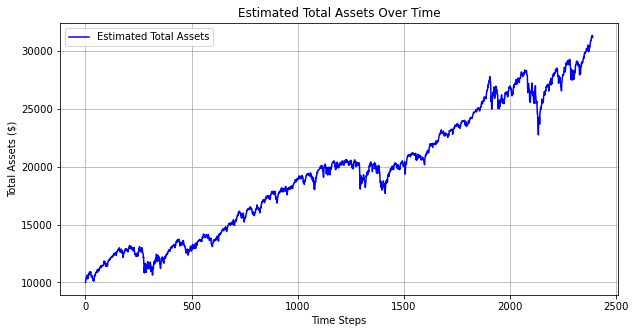

Final profits: 31169.83184383872


In [17]:
import plotly.graph_objects as go
import numpy as np

def test_dueling_ddqn(test_env, Q, buy_threshold=0.1, sell_threshold=0.8):
    pobs = test_env.reset()
    test_env.profits = 10000  # 重置初始资金
    test_acts = []
    test_rewards = []
    test_profits = []
    estimated_total_assets = [test_env.profits]  # 包括估算的持股价值的总资产列表
    while not test_env.done:
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data.ravel()
        action = np.random.choice(3, p=softmax_q_values)  # 随机选择行动，基于概率分布
        action_prob = softmax_q_values[action]

        # 设置交易的金额或数量，这里假设简单地将概率值转换为金额或比例
        amount = action_prob

        # 考虑不同行动的阈值
        if action == 1 and action_prob < buy_threshold:  # 买入行动的阈值判断
            action = 0  # 如果买入概率低于买入阈值，则不买入
            amount = 0
        elif action == 2 and action_prob < sell_threshold:  # 卖出行动的阈值判断
            action = 0  # 如果卖出概率低于卖出阈值，则不卖出
            amount = 0

        obs, reward, done = test_env.step(action, amount)
        test_acts.append(action)
        test_rewards.append(reward)
        pobs = obs

        # 估计每日的现有资金（假设所有持仓都卖出但不真正执行）
        simulated_profits = test_env.profits + sum(pos * test_env.data.iloc[test_env.t, :]['Close'] for pos in test_env.count)
        test_profits.append(simulated_profits)
        estimated_total_assets.append(simulated_profits)
    # 绘制折线图显示每日利润变化
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    test_env.profits = simulated_profits
    return test_acts, test_rewards, test_env.profits

def load_and_test_dueling_ddqn(test_env):
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
    chainer.serializers.load_npz('2001_SPY_dueling_ddqn_model.npz', Q_loaded)
    test_acts, test_rewards, test_profits = test_dueling_ddqn(test_env, Q_loaded, buy_threshold=0.1, sell_threshold=0.6)
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    print("Final profits:", test_profits)

test_data = test  # 这里应该是您加载或定义测试数据集的代码
test_env = Environment1(data=test_data, history_t=90)
load_and_test_dueling_ddqn(test_env)